# MCMC fitting to compare with stan HMC

Run the stan model we are going to compare to with
`

In [1]:
import os
import glob
import numpy as np
import emcee
import scipy.optimize
import matplotlib.pyplot as plt
import corner
# import multiprocessing as mp
import multiprocess as mp  # may need this if errors related to pickling lnprob
from scipy.special import jn_zeros
import galario.double as gd
from galario import arcsec
import frank
import arviz

import alma.image

import sys
sys.path.append('../src/vis_r')
import functions

# %matplotlib notebook

In [2]:
# this may be needed to avoid emcee hanging when using multiple threads
gd.threads(num=1)

1

In [3]:
# be nice, if you like
# niceness=os.nice(0)
# os.nice(11-niceness)

In [4]:
# import the visibilities, assuming alma.casa
uv_file = '../data/hr4796.selfcal.npy'
u, v, Re, Im, w, wavelength, ms_file = np.load(uv_file, allow_pickle=True)

# estimate re-weighting factor (so that chi^2 for null model would be 1, and d.o.f = 2*len(w))
reweight_factor = 2*len(w) / np.sum( (Re**2.0 + Im**2.0) * w )
print('reweighting factor is {}'.format(reweight_factor))

w *= reweight_factor

reweighting factor is 2.0716124238576996


In [5]:
# bin the data
sz = 4

u, v, Re, Im, w = functions.bin_uv(u, v, Re, Im, w, size_arcsec=sz)

u,v bin: 7348


(array([  16.,  852., 1458., 3453., 4969., 4485., 3085.,  990.,  165.,
          20.]),
 array([2.99555468, 3.32446297, 3.65337126, 3.98227954, 4.31118783,
        4.64009611, 4.9690044 , 5.29791268, 5.62682097, 5.95572926,
        6.28463754]),
 <BarContainer object of 10 artists>)

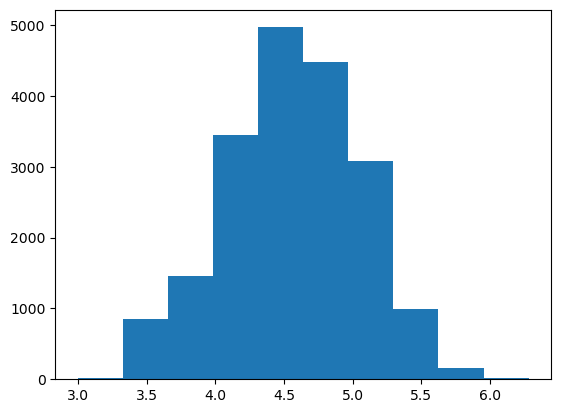

In [6]:
plt.hist(np.log10(w))

In [7]:
# set image properties, can alter f_max for higher or lower resolution
# (here 1.25 instead of 2.5, which gives speed at the cost of reduced accuracy)
nxy, dxy = gd.get_image_size(u, v, verbose=True)
dxy_arcsec = dxy / arcsec

dxy:1.795240e-02arcsec	nxy_MRS:2048
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:5.0 and MRS:7.353305e+00arcsec


In [8]:
# decide what model we want to use, and where we will put the results
model_name = 'gauss_3d'

In [9]:
# make the image object. by default this is asisymmetric
# (i.e. model='los_image_axisym', and has no anomaly parameter)
ii = alma.image.Image(arcsec_pix=dxy_arcsec, image_size=(nxy, nxy),
                      dens_model=model_name, z_fact=1, wavelength=wavelength)

model:los_image_axisym with density:gauss_3d and emit:rj_tail
parameters are ['$x_0$', '$y_0$', '$\\Omega$', '$i$', '$F$', '$r_0$', '$\\sigma_r$', '$\\sigma_h$']
rmax not set, run compute_rmax before generating images (may not apply to all density models)


In [10]:
# initial parameters, these need to be guessed
p0 = [0.030739811922506854,0.030302768261930402,26.657842043884354,76.65713506056193,
      0.015178783020528469,1.0784441832635718,0.05923657938474169, 0.04]

p0 = np.array(p0)

ii.p_ranges[-1] = [0.01, 10]
    
print('parameters and ranges for {}'.format(model_name))
for i in range(ii.n_params):
    print('{}\t{}\t{}'.format(p0[i],ii.p_ranges[i],ii.params[i]))

parameters and ranges for gauss_3d
0.030739811922506854	[-inf, inf]	$x_0$
0.030302768261930402	[-inf, inf]	$y_0$
26.657842043884354	[-270, 270]	$\Omega$
76.65713506056193	[0.0, 120]	$i$
0.015178783020528469	[0.0, inf]	$F$
1.0784441832635718	[0.0, inf]	$r_0$
0.05923657938474169	[0.001, inf]	$\sigma_r$
0.04	[0.01, 10]	$\sigma_h$


radial r_max: 70 pix at 1.712295052164697,1.687950475839001
model x,y,z extent 21, 69, 67
42.8 ms ± 6.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


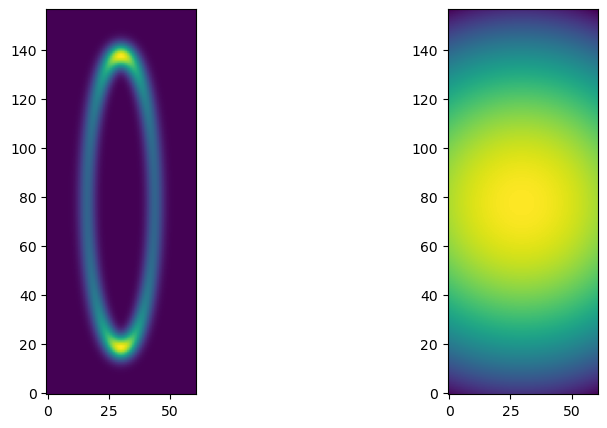

In [11]:
# set size of cutout used to generate images, which is based on the
# initial parameters. The tolerance in compute_rmax might be
# varied if the crop size turns out too large. We set 'zero_node'
# to True because we'll generate unrotated images, and let galario
# do the rest
ii.compute_rmax(p0, tol=1e-2, expand=10, zero_node=True, automask=False)

# this gives an idea of how long an mcmc might take
%timeit ii.image_galario(p0[3:])

# show an image and the primary beam
im = ii.image_galario(p0[3:])
fig,ax = plt.subplots(1,2, figsize=(9.5,5))
ax[0].imshow(im[ii.cc_gal], origin='lower')
# ax[0].contour(ii.mask, levels=[0,1], colors='black')
ax[1].imshow(ii.pb[0][ii.cc_gal], origin='lower')

In [12]:
def lnpostfn_img(p):
    """ Log of posterior probability function """

    for x,r in zip(p,ii.p_ranges):
        if x < r[0] or x > r[1]:
            return -np.inf

    # we generate the image with PA = North, origin in lower left,
    # and including primary beam correction
    image = ii.image_galario(p[3:]) * ii.pb_galario[0]

    # galario translates and rotates it for us
    chi2 = gd.chi2Image(image, dxy, u, v, Re, Im, w, origin='lower',
                        dRA = p[0]*arcsec, dDec = p[1]*arcsec, PA = np.deg2rad(p[2]) )

    # return the merit function, here we require the weights are normally distributed
    # about the model as a Gaussian with the correct normalisation
    # return -0.5 * ( chi2*p[-1] + np.sum(2*np.log(2*np.pi/(w*p[-1]))) )
    return -0.5 * chi2

nlnpostfn = lambda p: -lnpostfn(p)

set up DHT method

In [13]:
arcsec = np.pi/180/3600
arcsec2pi = arcsec*2*np.pi

In [14]:
uvmax = np.max(np.sqrt(u**2 + v**2))
uvmin = np.min(np.sqrt(u**2 + v**2))

fac = 1.5 # safety factor
r_max = jn_zeros(0, 1)[0] / (2*np.pi*uvmin*np.cos(np.deg2rad(p0[3]))) / arcsec * fac

nhpt = 1
while True:
    q_tmp = jn_zeros(0, nhpt)[-1]
    if q_tmp > uvmax * 2*np.pi*r_max*arcsec:
        break
    nhpt += 1

h = frank.hankel.DiscreteHankelTransform(r_max*arcsec, nhpt)
Rnk, Qnk = h.get_collocation_points(r_max*arcsec, nhpt)
Qzero = np.append(0, Qnk)
Ykm = h.coefficients(q=Qzero)

print(r_max, nhpt)
print(Qnk[0], Qnk[-1])
print(uvmin, uvmax)

30.48823989250086 381
2589.384182002593 1287961.0649321794
16830.37649895992 1287337.2812366155


In [15]:
# radial profile
prof = lambda r, p: np.exp(-0.5*np.square((r - p[5])/p[6]))

In [16]:
def lnpostfn_dht(p, test=False):
    # parameter bounds
    for x,r in zip(p,ii.p_ranges):
        if x < r[0] or x > r[1]:
            return -np.inf

    # u,v rotation
    urot, ruv = functions.uv_trans(u, v, np.deg2rad(p[2]), np.deg2rad(p[3]))
    # radial profile
    f = 1/2.35e-11*prof(Rnk/arcsec, p)
    fth = np.dot(Ykm, f)
    # normalise on shortest baseline
    fth = fth * p[4]/fth[0]
    # interpolate, frank has a method for this too
    # but it is about 10x slower
    # vis = h.interpolate(fth, ruv, space='Fourier')
    vis = np.interp(ruv, Qzero, fth)
    # vertical
    rz = p[7]*p[5]*np.sin(np.deg2rad(p[3])) * urot * arcsec2pi
    vis = vis * np.exp(-0.5*np.square(rz))
    # phase shift
    rot = (u*p[0] + v*p[1])*arcsec2pi
    vis = vis * np.exp(1j*rot)
    # chi^2
    chi2 = np.sum(((Re-vis.real)**2.0 + (Im-vis.imag)**2.0) * w)
    if test:
        print(-0.5*chi2)
        return ruv, fth, vis
    return -0.5 * chi2

In [17]:
# check it works
%timeit lnpostfn_img(p0)
%timeit lnpostfn_dht(p0)

print(lnpostfn_img(p0))
print(lnpostfn_dht(p0))

69.7 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
916 µs ± 8.91 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
-19173.66646767815
-19174.914445214796


In [74]:
# choose which method to use
if 1:
    lnpostfn = lnpostfn_img
    model_name += '_img'
else:
    lnpostfn = lnpostfn_dht
    model_name += '_visr'

outdir = f'../examples/{model_name}'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [75]:
# get a best fit to estimate mcmc starting params
res = scipy.optimize.minimize(nlnpostfn, p0, method='Nelder-Mead',
                             options={'maxiter':100})
# print(res['x'])
p0 = np.array(res['x'])
print(p0)
print(lnpostfn(p0))

[3.09816330e-02 3.12876497e-02 2.65833216e+01 7.65799559e+01
 1.50847706e-02 1.07729045e+00 5.90132156e-02 3.89554285e-02]
-19171.620833452704


In [76]:
# set up and run mcmc fitting
ndim = ii.n_params        # number of dimensions
nwalkers = 36             # number of walkers
nsteps = 1000               # total number of MCMC steps
nthreads = 6              # CPU threads that emcee should use

# we are using emcee v3
with mp.Pool(nthreads) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpostfn, pool=pool)

    # initialize the walkers with an ndim-dimensional Gaussian ball
    pos = [p0 + p0*0.01*np.random.randn(ndim) for i in range(nwalkers)]

    # execute the MCMC
    pos, prob, state = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 1000/1000 [17:43<00:00,  1.06s/it]


In [77]:
arviz.ess(arviz.from_emcee(sampler))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    var_0    float64 214.0
    var_1    float64 211.4
    var_2    float64 306.1
    var_3    float64 194.7
    var_4    float64 261.5
    var_5    float64 193.0
    var_6    float64 218.6
    var_7    float64 299.5

In [78]:
N = np.exp(np.linspace(np.log(100), np.log(sampler.chain.shape[1]), 10)).astype(int)
tau = np.empty((len(N), sampler.chain.shape[-1]))
for i, n in enumerate(N):
    for j in range(sampler.chain.shape[-1]):
        tau[i,j] = emcee.autocorr.integrated_time(sampler.chain[:, :n, j].T, quiet=True)

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [10.78910512]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [9.74724215]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [9.25657512]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [10.24806123]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [10.1017212]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and ru

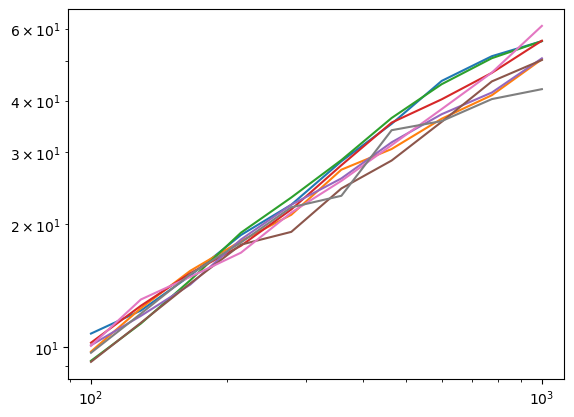

In [79]:
fig, ax = plt.subplots()
_ = ax.loglog(N, tau)

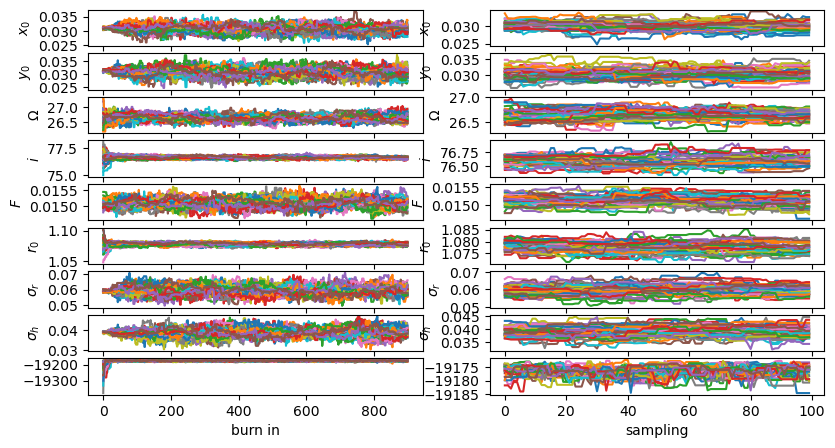

In [80]:
# see what the chains look like, skip a burn in period if desired
burn = 900
fig,ax = plt.subplots(ndim+1,2,figsize=(9.5,5),sharex='col',sharey=False)

for j in range(nwalkers):
    ax[-1,0].plot(sampler.lnprobability[j,:burn])
    for i in range(ndim):
        ax[i,0].plot(sampler.chain[j,:burn,i])
        ax[i,0].set_ylabel(ii.params[i])

for j in range(nwalkers):
    ax[-1,1].plot(sampler.lnprobability[j,burn:])
    for i in range(ndim):
        ax[i,1].plot(sampler.chain[j,burn:,i])
        ax[i,1].set_ylabel(ii.params[i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')
fig.savefig(outdir+'/chains-'+model_name+'.png')

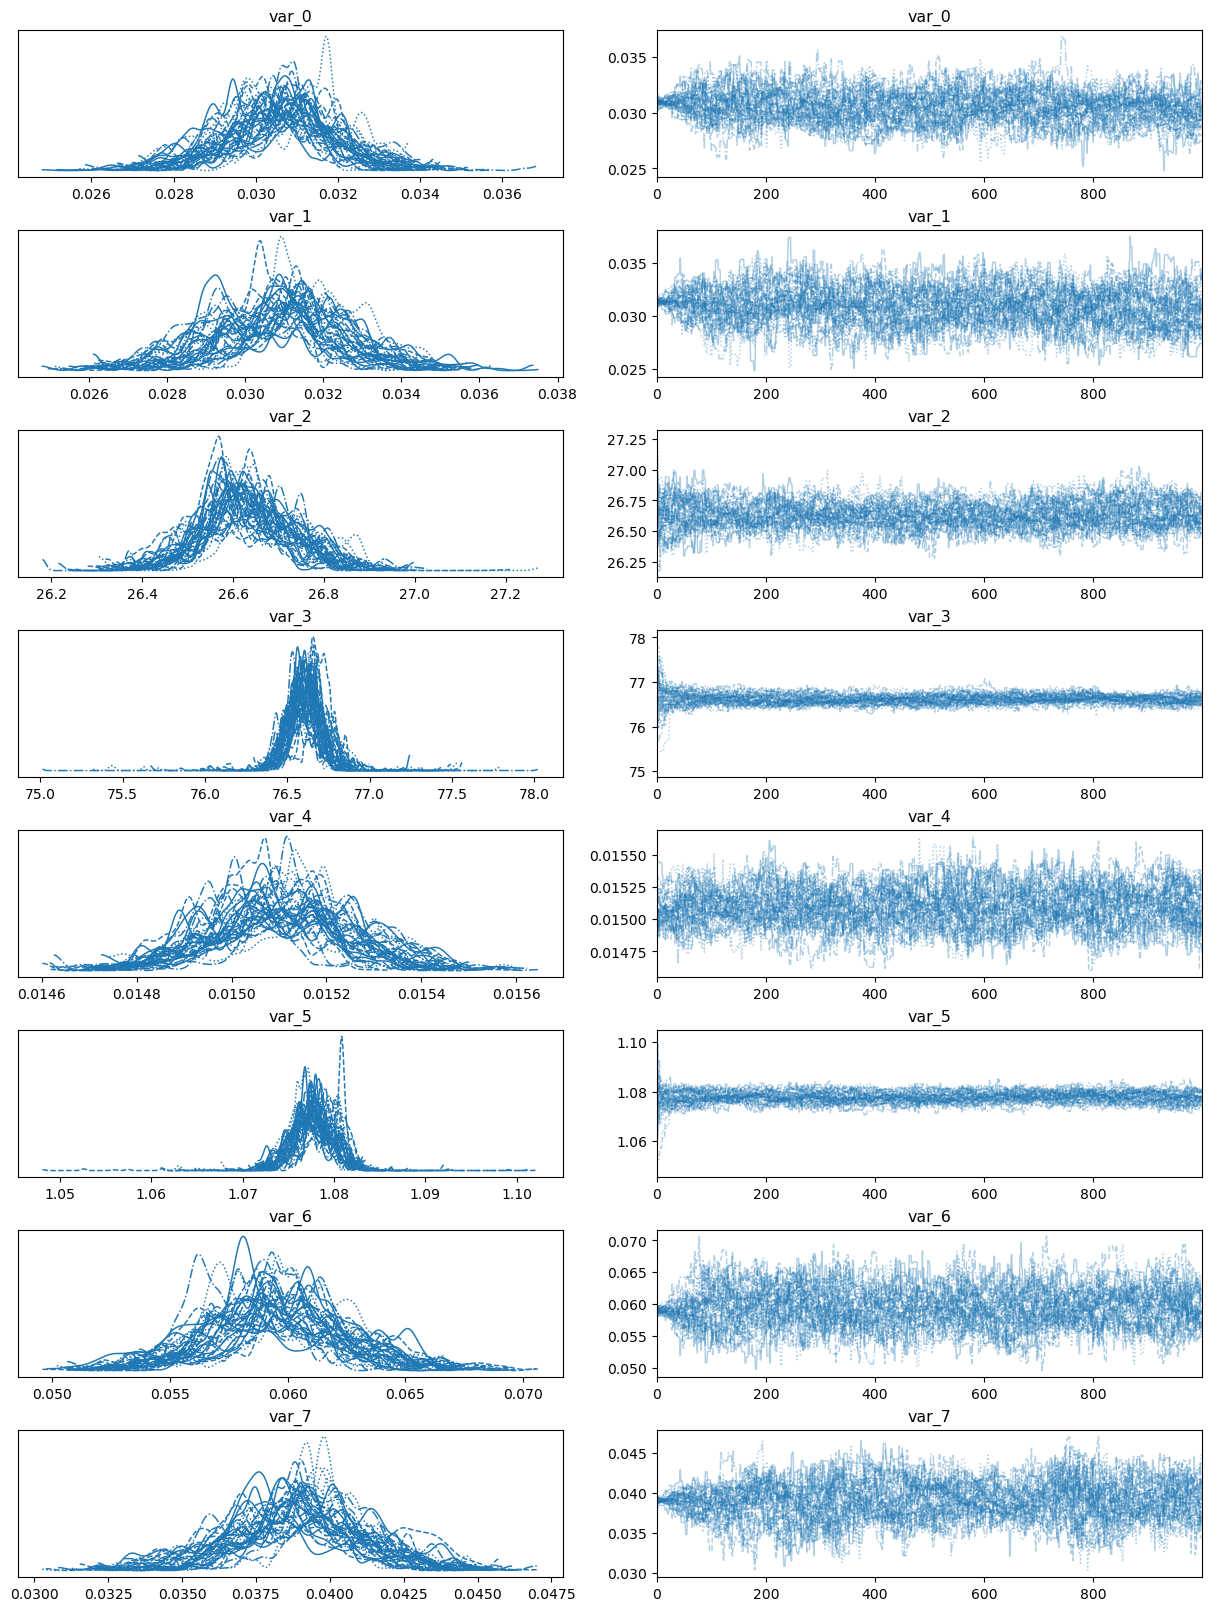

In [81]:
_ = arviz.plot_trace(arviz.from_emcee(sampler))

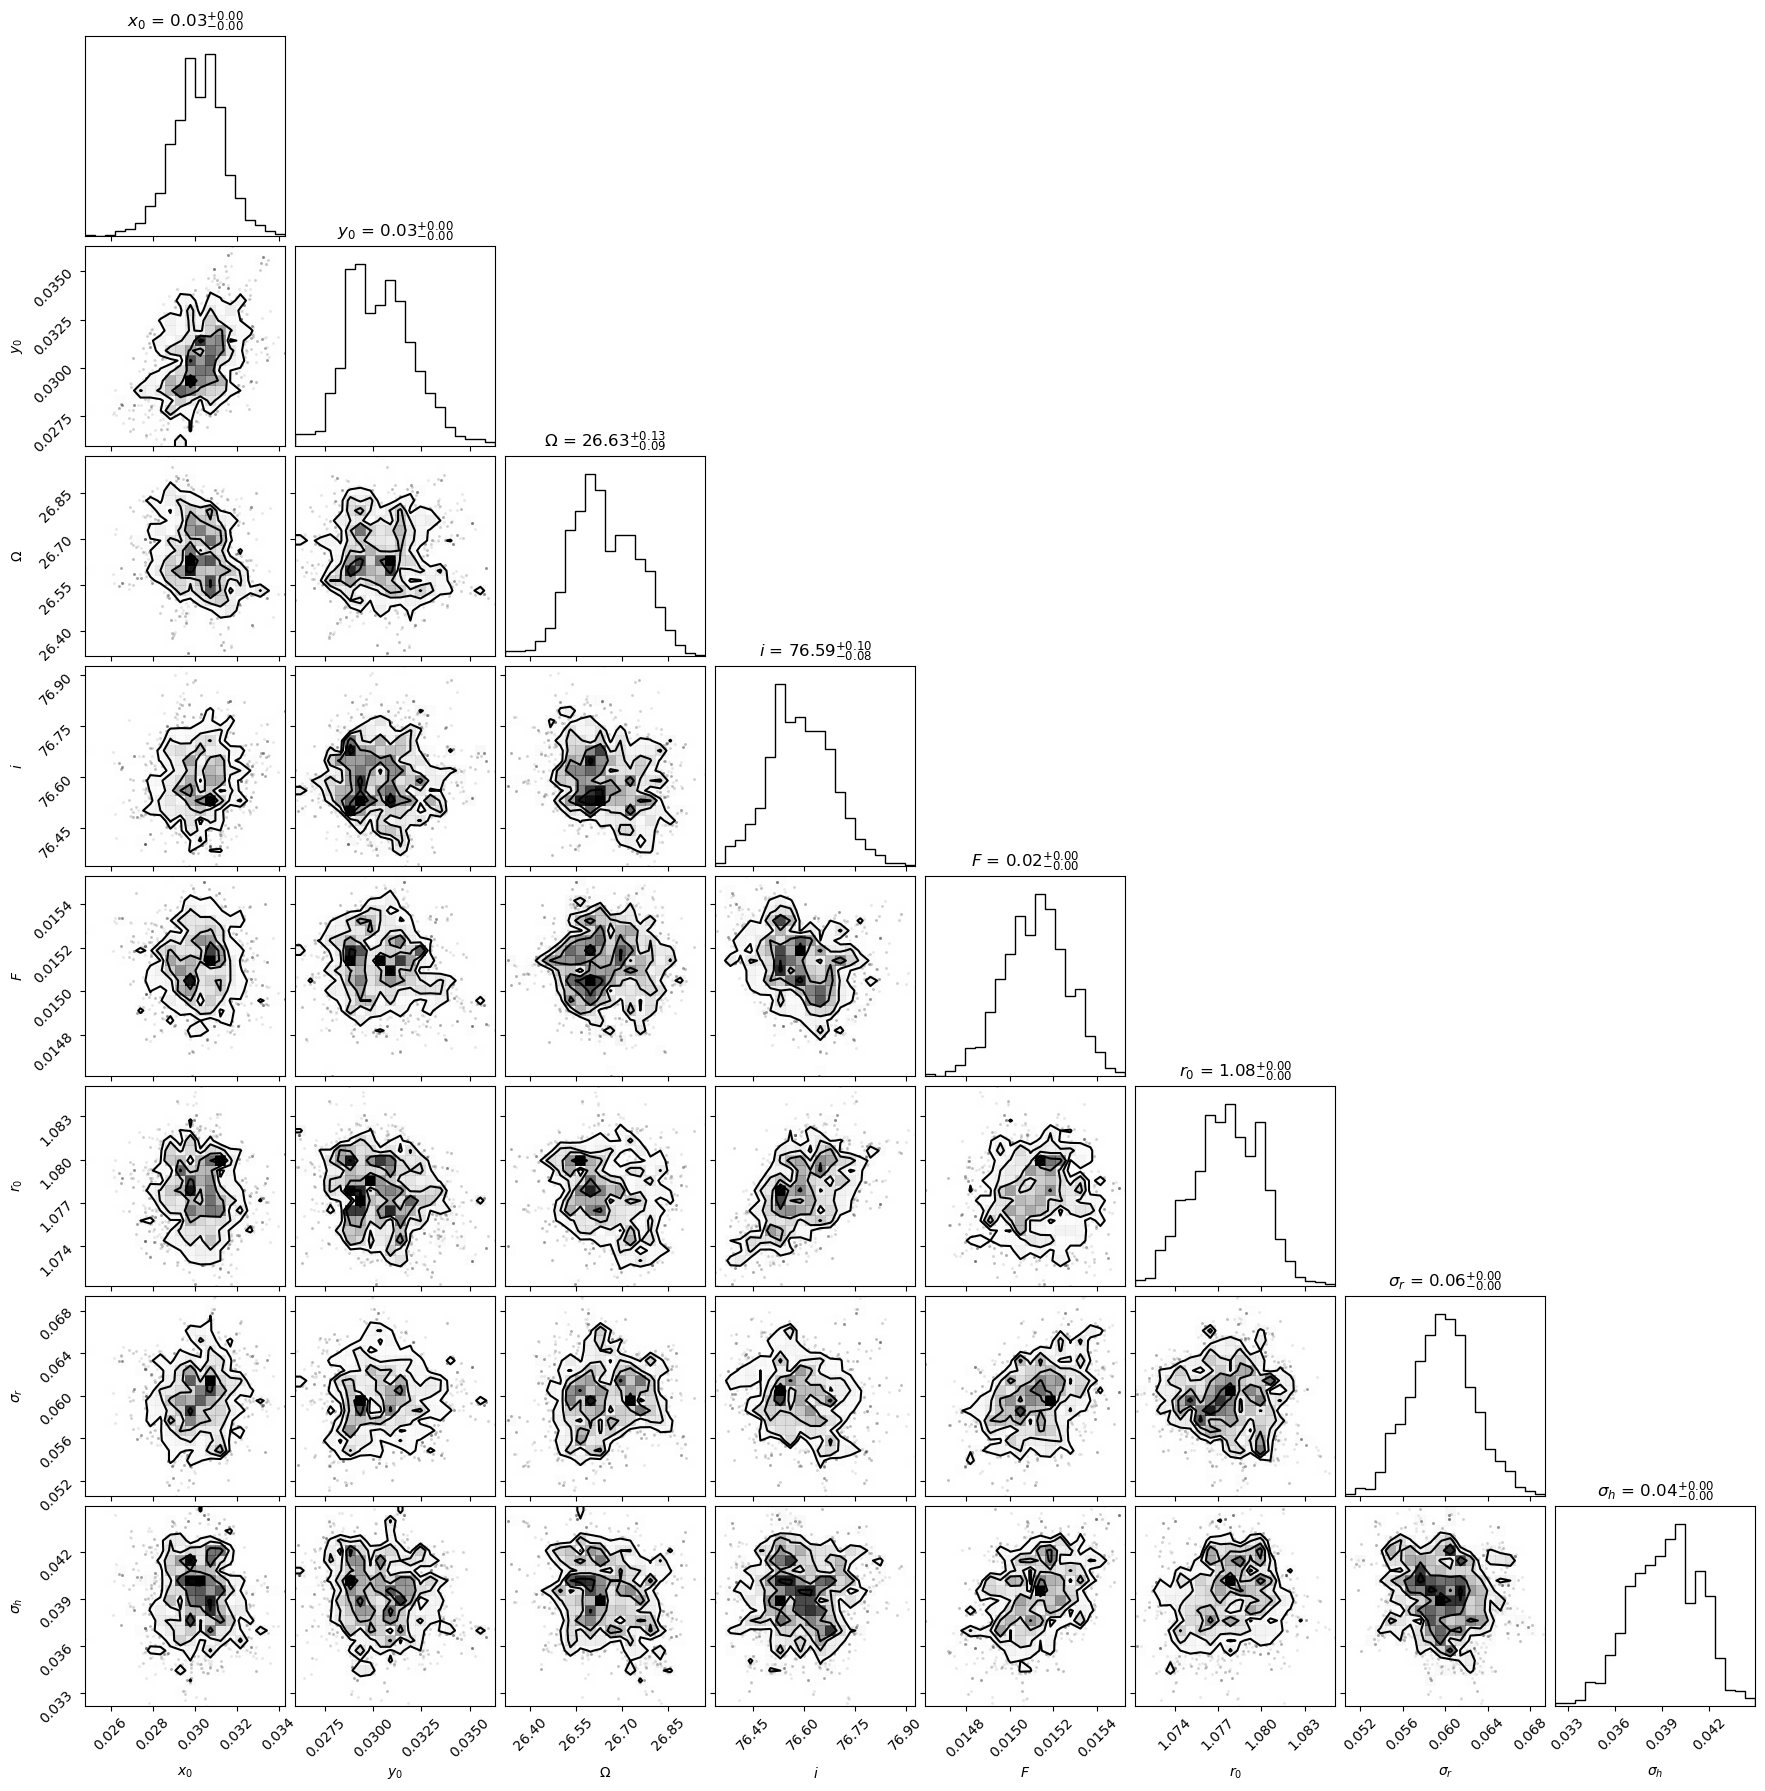

In [82]:
# make the corner plot
fig = corner.corner(sampler.chain[:,burn:,:].reshape((-1,ndim)), labels=ii.params,
                    show_titles=True)

fig.savefig(outdir+'/corner-'+model_name+'.png')

In [83]:
np.savez_compressed(outdir+'/chains-'+model_name+'.npz', sampler.chain, sampler.lnprobability)

In [84]:
# get the median parameters
p = np.median(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)
s = np.std(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)

print('best parameters and uncertainties for {}'.format(model_name))
for i in range(ii.n_params):
    print('{:g}\t{:g}\t{}'.format(p[i],s[i],ii.params[i]))
    
",".join([str(a) for a in p])

best parameters and uncertainties for gauss_3d_visr_img
0.0301818	0.00121072	$x_0$
0.0302777	0.00172192	$y_0$
26.6316	0.104422	$\Omega$
76.5901	0.09236	$i$
0.0151227	0.000143478	$F$
1.07774	0.00228147	$r_0$
0.0597914	0.00293111	$\sigma_r$
0.0393395	0.00213365	$\sigma_h$


'0.030181782042501205,0.03027765626085635,26.631636117444295,76.59005878305513,0.015122692555622735,1.0777362450156907,0.05979139847677213,0.0393395435895913'

-19174.186248003396


/Users/grant/opt/anaconda3/envs/casa/lib/python3.8/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


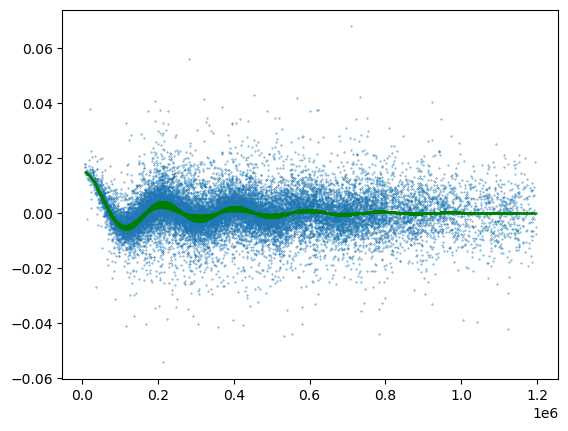

In [85]:
ruv, fth, vis = lnpostfn_dht(p, test=True)

fig, ax = plt.subplots()
ax.scatter(ruv, Re, s=0.1)
ax.scatter(ruv, vis, s=0.1, color='g')
# ax.scatter(ruv, vis.real)

# compare posteriors

In [52]:
fs = glob.glob('../examples/*/chain*[a-z].np[yz]')
fs.sort()
fs = fs[:3]
fs

['../examples/gauss_3d_img/chains-gauss_3d_img.npz',
 '../examples/stan_gauss/chains.npy',
 '../examples/vis-r_1gauss/chains.npy']

(36, 1000, 8)
(6, 300, 8)
(36, 1400, 8)


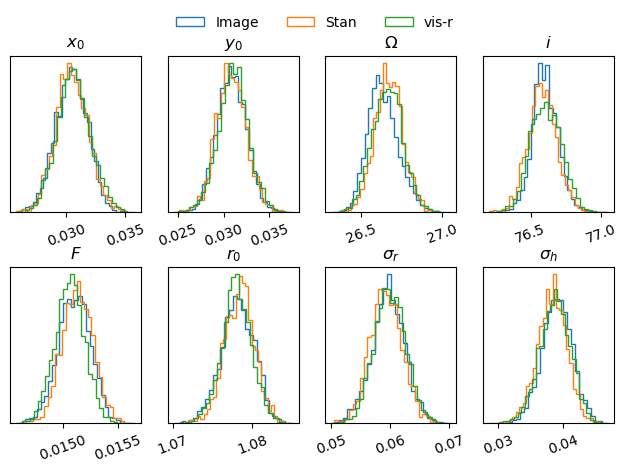

In [56]:
fig, ax = plt.subplots(2, 4)
a = ax.flatten()
lab = ['Image', 'Stan', 'vis-r']

for j,f in enumerate(fs):
    if 'npz' in f:
        chains = np.load(f)['arr_0']
    elif 'stan' in f:
        chains = np.moveaxis(np.load(f),0,-1)
        chains[:,:,2] *= 180/np.pi
        chains[:,:,3] *= 180/np.pi
    else:
        chains = np.load(f)
    print(chains.shape)
    for i in range(ii.n_params):
        if i == 0:
            a[i].hist(chains[:,-500:,i].flatten(), bins=30, histtype='step', density=True, label=lab[j], log=False)
        else:
            a[i].hist(chains[:,-500:,i].flatten(), bins=30, histtype='step', density=True, log=False)
        a[i].set_title(ii.params[i])
        a[i].get_yaxis().set_visible(False)

for _ in a:
    _.tick_params(axis='x', labelrotation=20)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.99),
             ncol=3, frameon=False)

fig.tight_layout()
fig.subplots_adjust(hspace=0.35, wspace=0.2, top=0.88)
fig.savefig('../doc/comp.png', dpi=150)

In [48]:
fs = glob.glob('../examples/vis-r_1gauss/chains-[0-9].npy')
fs.sort()
fs

['../examples/vis-r_1gauss/chains-1.npy',
 '../examples/vis-r_1gauss/chains-2.npy',
 '../examples/vis-r_1gauss/chains-3.npy',
 '../examples/vis-r_1gauss/chains-4.npy']

(36, 1400, 8)
(36, 1400, 8)
(36, 1400, 8)
(36, 1400, 8)


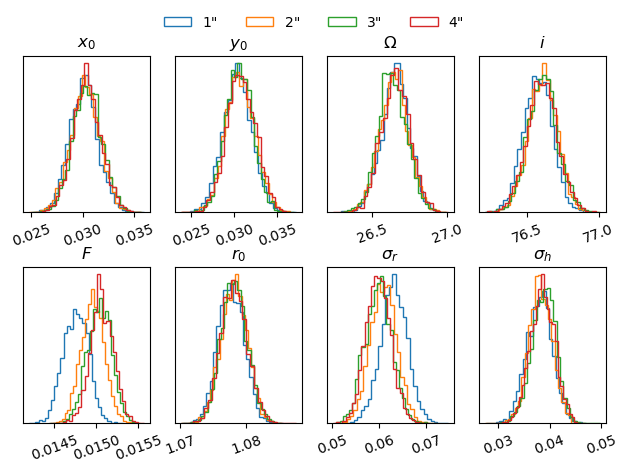

In [50]:
fig, ax = plt.subplots(2, 4)
a = ax.flatten()
lab = [1,2,3,4]

for j,f in enumerate(fs):
    if 'npz' in f:
        chains = np.load(f)['arr_0']
    elif 'stan' in f:
        chains = np.moveaxis(np.load(f),0,-1)
        chains[:,:,2] *= 180/np.pi
        chains[:,:,3] *= 180/np.pi
    else:
        chains = np.load(f)
    print(chains.shape)
    for i in range(ii.n_params):
        if i == 0:
            a[i].hist(chains[:,-500:,i].flatten(), bins=30, histtype='step', density=True, label=f'{lab[j]}"', log=False)
        else:
            a[i].hist(chains[:,-500:,i].flatten(), bins=30, histtype='step', density=True, log=False)
        a[i].set_title(ii.params[i])
        a[i].get_yaxis().set_visible(False)

for _ in a:
    _.tick_params(axis='x', labelrotation=20)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.99),
           ncol=4, frameon=False)

# a[0].legend(frameon=False)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35, wspace=0.2, top=0.88)
fig.savefig('../doc/avg.png', dpi=150)